In [2]:
#### Etape1 Importation des bibliothèques #######
# Importation des bibliothèques nécessaires
import pandas as pd  # Manipulation des données
import numpy as np  # Calculs mathématiques
import matplotlib.pyplot as plt  # Visualisation des données
import seaborn as sns  # Visualisation avancée des données
from sklearn.model_selection import train_test_split  # Division des données en train/test
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Normalisation et encodage
from sklearn.tree import DecisionTreeClassifier  # Modèle d'arbre de décision
from sklearn.cluster import KMeans  # Modèle de clustering K-Means
from sklearn.metrics import classification_report, accuracy_score  # Évaluation des modèles
from keras.models import Sequential  # Construction du modèle CNN
from keras.layers import Dense, Dropout  # Couches du modèle CNN

In [3]:
data = pd.read_csv('dataset_phishing.csv')  # Remplacer par le nom de votre fichier

# Afficher les colonnes disponibles
print("Colonnes du dataset :")
print(data.columns)


Colonnes du dataset :
Index(['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens',
       'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore',
       'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma',
       'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com',
       'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'punycode', 'port', 'tld_in_path',
       'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains',
       'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       

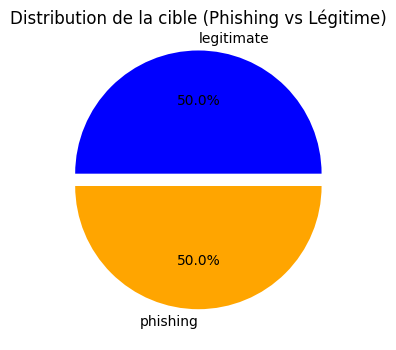

In [4]:
# Visualisation de la distribution de la cible
plt.figure(figsize=(6, 4))
data['status'].value_counts(normalize=True).plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['blue', 'orange'],
    explode=[0.1, 0]
    )
plt.title('Distribution de la cible (Phishing vs Légitime)')
plt.ylabel('')
plt.show()

In [5]:
# Séparer les colonnes numériques et non numériques
numeric_cols = data.select_dtypes(include=['number']).columns  # Colonnes numériques
non_numeric_cols = data.select_dtypes(exclude=['number']).columns  # Colonnes non numériques

# Gestion des valeurs manquantes : Remplir les colonnes numériques avec la moyenne
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Gestion des valeurs manquantes pour les colonnes non numériques : Remplir par une valeur par défaut (ex: "unknown")
data[non_numeric_cols] = data[non_numeric_cols].fillna("unknown")

# Encodage des variables catégoriques en numériques si nécessaire
label_encoder = LabelEncoder()
for col in non_numeric_cols:
    data[col] = label_encoder.fit_transform(data[col])

# Séparation des caractéristiques (X) et de la cible (y)
X = data.drop('status', axis=1)  # Toutes les colonnes sauf la cible
y = data['status']  # Colonne cible

# Normalisation des caractéristiques
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Division en ensembles d'entraînement et de test (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train.shape

(9144, 88)

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize the Random Forest Classifier
tree_model = RandomForestClassifier(random_state=42)

# Fit the model on the training data
tree_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_tree = tree_model.predict(X_test)

# Evaluation of the Random Forest model
print("\nÉvaluation du modèle Arbre de Décision :")
print(classification_report(y_test, y_pred_tree))


Évaluation du modèle Arbre de Décision :
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1157
           1       0.97      0.96      0.97      1129

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286



**BiGRU**

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tqdm import tqdm
import time

# Constants
BATCH_SIZE = 32
NUM_ROUNDS = 30
NUM_CLIENTS = 4  # Minimum must be 2
PROXIMAL_COEFFICIENT = 0.1  # Adjust this as needed
LOCAL_EPOCHS = 2  # Number of local epochs

# Declare lists for tracking global accuracy and loss
global_accuracy_list_BiGRU = []
global_loss_list_BiGRU = []

# Check the shape of X_train
print("X_train shape before reshaping:", X_train.shape)

# Reshape X_train if necessary
if len(X_train.shape) == 2:  # (samples, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, time_steps=1, features)

# Reshape X_test if necessary
if len(X_test.shape) == 2:  # (samples, features)
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # (samples, time_steps=1, features)

# Step 1: Define the Model Creation Function
def create_model():
    model = Sequential()
    model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))  # Input layer
    model.add(Dropout(0.5))  # Regularization
    model.add(Bidirectional(GRU(64)))  # Second BiGRU layer
    model.add(Dropout(0.5))  # Regularization
    model.add(Dense(1, activation='sigmoid'))  # Output layer (binary)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize global model
global_model = create_model()

# Measure wall time and CPU time
start_time_wall = time.time()
start_time_cpu = time.process_time()

for round_num in range(NUM_ROUNDS):
    print(f'ROUND #{round_num + 1}/{NUM_ROUNDS} ')

    # Client preparation
    client_models = []
    for client_id in range(NUM_CLIENTS):
        client_model = create_model()
        client_model.set_weights(global_model.get_weights())  # Initialize with global model
        client_models.append(client_model)

    # Training on local data
    for client_id in tqdm(range(NUM_CLIENTS)):
        print(f'___________________Training CLIENT #{client_id + 1}')

        # Allocating data to each client
        start = client_id * (len(X_train) // NUM_CLIENTS)
        end = (client_id + 1) * (len(X_train) // NUM_CLIENTS)
        X_train_i = X_train[start:end]
        y_train_i = y_train[start:end]

        # Convert y_train_i to numpy and reshape it to (samples, 1)
        y_train_i = np.array(y_train_i).reshape(-1, 1)

        # Local training with FedProx
        for epoch in range(LOCAL_EPOCHS):  # Number of local epochs
            with tf.GradientTape() as tape:
                # Forward pass
                predictions = client_models[client_id](X_train_i, training=True)
                loss = tf.keras.losses.binary_crossentropy(y_train_i, predictions)

                # Compute the FedProx regularization term
                proximal_term = PROXIMAL_COEFFICIENT * tf.add_n([
                    tf.reduce_sum(tf.square(w - g))
                    for w, g in zip(client_models[client_id].trainable_weights, global_model.trainable_weights)
                ])
                
                total_loss = tf.reduce_mean(loss) + proximal_term
            # Compute gradients and apply updates
            grads = tape.gradient(total_loss, client_models[client_id].trainable_weights)
            client_models[client_id].optimizer.apply_gradients(zip(grads, client_models[client_id].trainable_weights))

    # Global Aggregation
    new_weights = [np.mean([client_models[i].get_weights()[layer] for i in range(NUM_CLIENTS)], axis=0) for layer in range(len(global_model.get_weights()))]
    global_model.set_weights(new_weights)

    # Evaluate the global model on training data
    loss, acc = global_model.evaluate(X_train, y_train, verbose=0)
    print(f'Global Train Loss: {loss}, Global Train Accuracy: {acc}')

    # Evaluate on X_test
    loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
    print(f'Global Validation Loss: {loss}, Global Validation Accuracy: {acc}\n_________________________________________________________')

    # Append the global loss and accuracy to their respective lists
    global_loss_list_BiGRU.append(loss)
    global_accuracy_list_BiGRU.append(acc)

# Measure end time for wall time
end_time_wall = time.time()
end_time_cpu = time.process_time()

# Calculate and print wall time and CPU time
wall_time = end_time_wall - start_time_wall
cpu_time = end_time_cpu - start_time_cpu

print(f'Total Wall Time: {wall_time:.2f} seconds')
print(f'Total CPU Time: {cpu_time:.2f} seconds')

# Optional: Save the final global model
# global_model.save("final_global_model.keras")

# Print the final global loss and accuracy lists
print("Global Loss List (BiGRU):", global_loss_list_BiGRU)
print("Global Accuracy List (BiGRU):", global_accuracy_list_BiGRU)


X_train shape before reshaping: (9144, 88)
ROUND #1/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 50%|██████████████████████████████████████████                                          | 2/4 [00:04<00:03,  1.86s/it]

___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.19s/it]

___________________Training CLIENT #4
Global Train Loss: 0.6044082045555115, Global Train Accuracy: 0.8370516300201416
Global Validation Loss: 0.6027057766914368, Global Validation Accuracy: 0.8385826945304871
_________________________________________________________
ROUND #2/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.83it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.17it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.89it/s]

Global Train Loss: 0.5238648653030396, Global Train Accuracy: 0.8632983565330505
Global Validation Loss: 0.519192099571228, Global Validation Accuracy: 0.8718284964561462
_________________________________________________________
ROUND #3/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.22it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.23it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.16it/s]

Global Train Loss: 0.4532289206981659, Global Train Accuracy: 0.8724846839904785
Global Validation Loss: 0.4461587369441986, Global Validation Accuracy: 0.8836395740509033
_________________________________________________________
ROUND #4/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.03it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.26it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.93it/s]

Global Train Loss: 0.3929353356361389, Global Train Accuracy: 0.8792650699615479
Global Validation Loss: 0.3841356933116913, Global Validation Accuracy: 0.8893263339996338
_________________________________________________________
ROUND #5/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.36it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.58it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77it/s]

Global Train Loss: 0.34356701374053955, Global Train Accuracy: 0.8873578310012817
Global Validation Loss: 0.333699494600296, Global Validation Accuracy: 0.8945756554603577
_________________________________________________________
ROUND #6/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.67it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.01it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.11it/s]

Global Train Loss: 0.30356326699256897, Global Train Accuracy: 0.896216094493866
Global Validation Loss: 0.2930787205696106, Global Validation Accuracy: 0.9011373519897461
_________________________________________________________
ROUND #7/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.81it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.12it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.01it/s]

Global Train Loss: 0.270776629447937, Global Train Accuracy: 0.9044181704521179
Global Validation Loss: 0.2600720226764679, Global Validation Accuracy: 0.9120734930038452
_________________________________________________________
ROUND #8/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.37it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.24it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.26it/s]

Global Train Loss: 0.2438349425792694, Global Train Accuracy: 0.9154636859893799
Global Validation Loss: 0.23307785391807556, Global Validation Accuracy: 0.9221347570419312
_________________________________________________________
ROUND #9/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.29it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.46it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]

Global Train Loss: 0.22193346917629242, Global Train Accuracy: 0.9215879440307617
Global Validation Loss: 0.2108744978904724, Global Validation Accuracy: 0.9300087690353394
_________________________________________________________
ROUND #10/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.58it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.87it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.18it/s]

Global Train Loss: 0.20420022308826447, Global Train Accuracy: 0.9284777045249939
Global Validation Loss: 0.1927562952041626, Global Validation Accuracy: 0.9356955289840698
_________________________________________________________
ROUND #11/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.90it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.65it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.64it/s]

Global Train Loss: 0.1900830715894699, Global Train Accuracy: 0.932414710521698
Global Validation Loss: 0.1779855340719223, Global Validation Accuracy: 0.9413823485374451
_________________________________________________________
ROUND #12/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  8.29it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.81it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]

Global Train Loss: 0.17895390093326569, Global Train Accuracy: 0.9356955289840698
Global Validation Loss: 0.1661263406276703, Global Validation Accuracy: 0.9453193545341492
_________________________________________________________
ROUND #13/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.08it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.56it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.55it/s]

Global Train Loss: 0.17027398943901062, Global Train Accuracy: 0.9397419095039368
Global Validation Loss: 0.15685871243476868, Global Validation Accuracy: 0.9461942315101624
_________________________________________________________
ROUND #14/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.55it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.42it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00it/s]

Global Train Loss: 0.16333748400211334, Global Train Accuracy: 0.9418197870254517
Global Validation Loss: 0.14924602210521698, Global Validation Accuracy: 0.9470691084861755
_________________________________________________________
ROUND #15/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.98it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.45it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]

Global Train Loss: 0.1577896773815155, Global Train Accuracy: 0.9428040385246277
Global Validation Loss: 0.1430656760931015, Global Validation Accuracy: 0.9492563605308533
_________________________________________________________
ROUND #16/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.67it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.23it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]

Global Train Loss: 0.15343719720840454, Global Train Accuracy: 0.9446631669998169
Global Validation Loss: 0.1381974071264267, Global Validation Accuracy: 0.9501312375068665
_________________________________________________________
ROUND #17/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.55it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.08it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12it/s]

Global Train Loss: 0.14994105696678162, Global Train Accuracy: 0.9449912309646606
Global Validation Loss: 0.13438652455806732, Global Validation Accuracy: 0.950568675994873
_________________________________________________________
ROUND #18/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.69it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.18it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.26it/s]

Global Train Loss: 0.14704842865467072, Global Train Accuracy: 0.9457567930221558
Global Validation Loss: 0.1310492753982544, Global Validation Accuracy: 0.9514435529708862
_________________________________________________________
ROUND #19/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.48it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.44it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]

Global Train Loss: 0.14466838538646698, Global Train Accuracy: 0.9470691084861755
Global Validation Loss: 0.12840613722801208, Global Validation Accuracy: 0.9531933665275574
_________________________________________________________
ROUND #20/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.96it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.75it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]

Global Train Loss: 0.14276963472366333, Global Train Accuracy: 0.947615921497345
Global Validation Loss: 0.1264098584651947, Global Validation Accuracy: 0.9531933665275574
_________________________________________________________
ROUND #21/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.99it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.19it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.18it/s]

Global Train Loss: 0.14102314412593842, Global Train Accuracy: 0.9478346705436707
Global Validation Loss: 0.12462862581014633, Global Validation Accuracy: 0.9545056819915771
_________________________________________________________
ROUND #22/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.79it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.42it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.37it/s]

Global Train Loss: 0.1394065022468567, Global Train Accuracy: 0.9487095475196838
Global Validation Loss: 0.12289556860923767, Global Validation Accuracy: 0.9558179974555969
_________________________________________________________
ROUND #23/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.55it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.85it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]

Global Train Loss: 0.13796967267990112, Global Train Accuracy: 0.9490376114845276
Global Validation Loss: 0.12172392755746841, Global Validation Accuracy: 0.9562554955482483
_________________________________________________________
ROUND #24/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.50it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.34it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.18it/s]

Global Train Loss: 0.13667021691799164, Global Train Accuracy: 0.9492563605308533
Global Validation Loss: 0.12046298384666443, Global Validation Accuracy: 0.9566929340362549
_________________________________________________________
ROUND #25/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.94it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.07it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.92it/s]

Global Train Loss: 0.13547392189502716, Global Train Accuracy: 0.9493656754493713
Global Validation Loss: 0.11899898201227188, Global Validation Accuracy: 0.9566929340362549
_________________________________________________________
ROUND #26/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.42it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.46it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]

Global Train Loss: 0.13432523608207703, Global Train Accuracy: 0.9511154890060425
Global Validation Loss: 0.11825349181890488, Global Validation Accuracy: 0.9588801264762878
_________________________________________________________
ROUND #27/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.81it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.17it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.06it/s]

Global Train Loss: 0.1332543045282364, Global Train Accuracy: 0.9513341784477234
Global Validation Loss: 0.11735191941261292, Global Validation Accuracy: 0.959755003452301
_________________________________________________________
ROUND #28/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  5.94it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.40it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.20it/s]

Global Train Loss: 0.13225972652435303, Global Train Accuracy: 0.9520997405052185
Global Validation Loss: 0.11654745787382126, Global Validation Accuracy: 0.9593175649642944
_________________________________________________________
ROUND #29/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.87it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.87it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.01it/s]

Global Train Loss: 0.13130928575992584, Global Train Accuracy: 0.9517716765403748
Global Validation Loss: 0.11567232757806778, Global Validation Accuracy: 0.959755003452301
_________________________________________________________
ROUND #30/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.08it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.41it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]

Global Train Loss: 0.13048912584781647, Global Train Accuracy: 0.9522091150283813
Global Validation Loss: 0.11521296203136444, Global Validation Accuracy: 0.960629940032959
_________________________________________________________
Total Wall Time: 155.69 seconds
Total CPU Time: 44.41 seconds
Global Loss List (BiGRU): [0.6027057766914368, 0.519192099571228, 0.4461587369441986, 0.3841356933116913, 0.333699494600296, 0.2930787205696106, 0.2600720226764679, 0.23307785391807556, 0.2108744978904724, 0.1927562952041626, 0.1779855340719223, 0.1661263406276703, 0.15685871243476868, 0.14924602210521698, 0.1430656760931015, 0.1381974071264267, 0.13438652455806732, 0.1310492753982544, 0.12840613722801208, 0.1264098584651947, 0.12462862581014633, 0.12289556860923767, 0.12172392755746841, 0.12046298384666443, 0.11899898201227188, 0.11825349181890488, 0.11735191941261292, 0.11654745787382126, 0.11567232757806778, 0.11521296203136444]
Global Accuracy List (BiGRU): [0.8385826945304871, 0.87182849645614

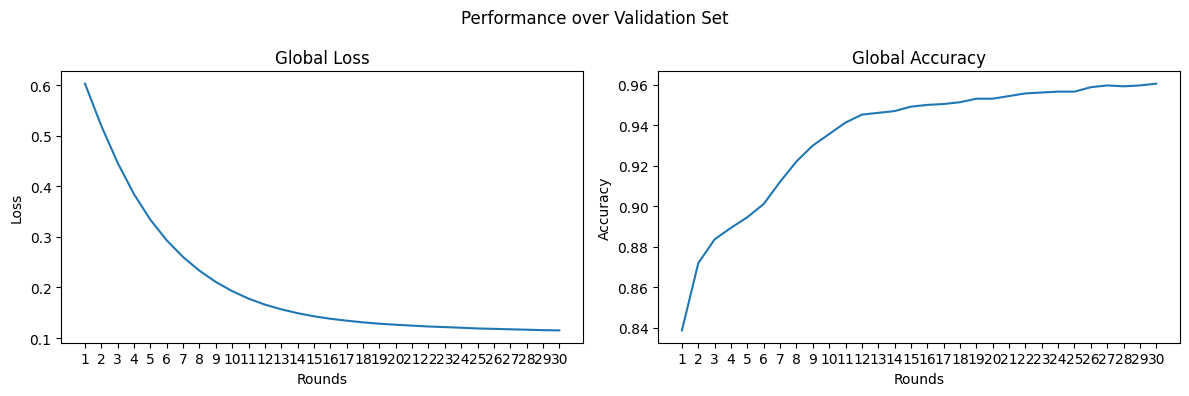

In [9]:
import matplotlib.pyplot as plt

plt.style.use('default')
plt.figure(figsize=(12, 4))
plt.suptitle("Performance over Validation Set")

# Plot for Global Loss
plt.subplot(121)
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.plot(range(1, len(global_loss_list_BiGRU) + 1), global_loss_list_BiGRU)
plt.xticks(range(1, len(global_loss_list_BiGRU) + 1))
plt.title("Global Loss")

# Plot for Global Accuracy
plt.subplot(122)
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.plot(range(1, len(global_accuracy_list_BiGRU) + 1), global_accuracy_list_BiGRU)
plt.xticks(range(1, len(global_accuracy_list_BiGRU) + 1))
plt.title("Global Accuracy")

plt.tight_layout()
plt.show()


In [10]:
import tensorflow as tf
from sklearn.metrics import classification_report

# Generate predictions
predictions = global_model.predict(X_test)

# Convert probabilities to binary labels
predicted_labels = (predictions > 0.5).astype("int32").flatten()  # Convert to 1D array

# Check the shape of y_test
print("y_test shape:", y_test.shape)

# If y_test is one-hot encoded, convert it to binary labels
if len(y_test.shape) == 2 and y_test.shape[1] == 2:  # Assuming two classes
    true_labels = tf.argmax(y_test, axis=1).numpy()  # Convert to 1D array
else:
    true_labels = y_test  # Already 1D array

# Print classification metrics
class_report = classification_report(true_labels, predicted_labels, digits=6, zero_division=0)
print(class_report)

72/72 [==============================] - 1s 3ms/step
y_test shape: (2286,)
              precision    recall  f1-score   support

           0   0.961905  0.960242  0.961073      1157
           1   0.959328  0.961027  0.960177      1129

    accuracy                       0.960630      2286
   macro avg   0.960616  0.960635  0.960625      2286
weighted avg   0.960632  0.960630  0.960630      2286



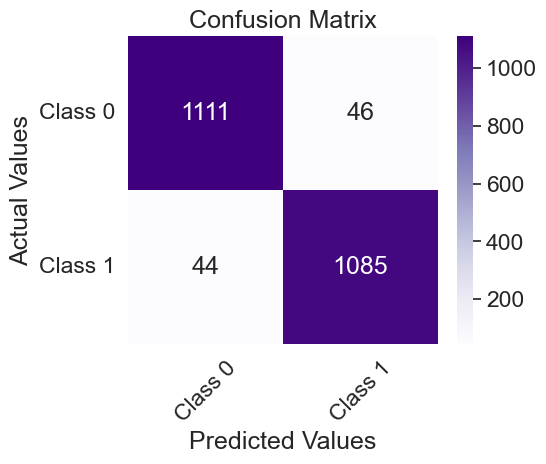

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming true_labels and predicted_labels are already defined

# Define class names for your binary classification
class_names = ['Class 0', 'Class 1']  # Replace with your actual class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.5)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=True, 
                 xticklabels=class_names, yticklabels=class_names)

# Labeling the axes
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names, rotation=0)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Show the plot
plt.title('Confusion Matrix')
plt.show()

In [14]:
train_loss, train_acc = global_model.evaluate(X_train, y_train)
print(f"Global Train Accuracy : {train_acc}")
print(f"Global Train Loss : {train_loss}")


val_loss, val_acc = global_model.evaluate(X_test, y_test)
print(f"Global Validation Accuracy : {val_acc}")
print(f"Global Validation Loss : {val_loss}")
     

286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9501 - loss: 0.1340
Global Train Accuracy : 0.9527559280395508
Global Train Loss : 0.12915222346782684
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9612 - loss: 0.1103
Global Validation Accuracy : 0.959755003452301
Global Validation Loss : 0.11465408653020859


#**GRU**

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tqdm import tqdm
import time

# Constants
BATCH_SIZE = 32
NUM_ROUNDS = 30
NUM_CLIENTS = 4  # Minimum must be 2
PROXIMAL_COEFFICIENT = 0.1  # Adjust this as needed
LOCAL_EPOCHS = 2  # Number of local epochs

# Declare lists for tracking global accuracy and loss
global_accuracy_list_GRU = []
global_loss_list_GRU = []

# Check the shape of X_train
print("X_train shape before reshaping:", X_train.shape)

# Reshape X_train if necessary
if len(X_train.shape) == 2:  # (samples, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, time_steps=1, features)

# Reshape X_test if necessary
if len(X_test.shape) == 2:  # (samples, features)
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # (samples, time_steps=1, features)

# Step 1: Define the Model Creation Function with GRU
def create_model():
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  # First GRU layer
    model.add(Dropout(0.5))  # Regularization
    model.add(GRU(64))  # Second GRU layer
    model.add(Dropout(0.5))  # Regularization
    model.add(Dense(1, activation='sigmoid'))  # Output layer (binary)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize global model
global_model = create_model()

# Measure wall time and CPU time
start_time_wall = time.time()
start_time_cpu = time.process_time()

for round_num in range(NUM_ROUNDS):
    print(f'ROUND #{round_num + 1}/{NUM_ROUNDS} ')

    # Client preparation
    client_models = []
    for client_id in range(NUM_CLIENTS):
        client_model = create_model()
        client_model.set_weights(global_model.get_weights())  # Initialize with global model
        client_models.append(client_model)

    # Training on local data
    for client_id in tqdm(range(NUM_CLIENTS)):
        print(f'___________________Training CLIENT #{client_id + 1}')

        # Allocating data to each client
        start = client_id * (len(X_train) // NUM_CLIENTS)
        end = (client_id + 1) * (len(X_train) // NUM_CLIENTS)
        X_train_i = X_train[start:end]
        y_train_i = y_train[start:end]

        # Convert y_train_i to numpy and reshape it to (samples, 1)
        y_train_i = np.array(y_train_i).reshape(-1, 1)

        # Local training with FedProx
        for epoch in range(LOCAL_EPOCHS):  # Number of local epochs
            with tf.GradientTape() as tape:
                # Forward pass
                predictions = client_models[client_id](X_train_i, training=True)
                loss = tf.keras.losses.binary_crossentropy(y_train_i, predictions)

                # Compute the FedProx regularization term
                proximal_term = PROXIMAL_COEFFICIENT * tf.add_n([
                    tf.reduce_sum(tf.square(w - g))
                    for w, g in zip(client_models[client_id].trainable_weights, global_model.trainable_weights)
                ])
                
                total_loss = tf.reduce_mean(loss) + proximal_term
            # Compute gradients and apply updates
            grads = tape.gradient(total_loss, client_models[client_id].trainable_weights)
            client_models[client_id].optimizer.apply_gradients(zip(grads, client_models[client_id].trainable_weights))

    # Global Aggregation
    new_weights = [np.mean([client_models[i].get_weights()[layer] for i in range(NUM_CLIENTS)], axis=0) for layer in range(len(global_model.get_weights()))]
    global_model.set_weights(new_weights)

    # Evaluate the global model on training data
    loss, acc = global_model.evaluate(X_train, y_train, verbose=0)
    print(f'Global Train Loss: {loss}, Global Train Accuracy: {acc}')

    # Evaluate on X_test
    loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
    print(f'Global Validation Loss: {loss}, Global Validation Accuracy: {acc}\n_________________________________________________________')

    # Append the global loss and accuracy to their respective lists
    global_loss_list_GRU.append(loss)
    global_accuracy_list_GRU.append(acc)

# Measure end time for wall time
end_time_wall = time.time()
end_time_cpu = time.process_time()

# Calculate and print wall time and CPU time
wall_time = end_time_wall - start_time_wall
cpu_time = end_time_cpu - start_time_cpu

print(f'Total Wall Time: {wall_time:.2f} seconds')
print(f'Total CPU Time: {cpu_time:.2f} seconds')

# Optional: Save the final global model
# global_model.save("final_global_model_GRU.keras")

# Print the final global loss and accuracy lists
print("Global Loss List (GRU):", global_loss_list_GRU)
print("Global Accuracy List (GRU):", global_accuracy_list_GRU)


X_train shape before reshaping: (9144, 1, 88)
ROUND #1/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  9.91it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.11it/s]

___________________Training CLIENT #4
Global Train Loss: 0.6657119989395142, Global Train Accuracy: 0.648184597492218
Global Validation Loss: 0.6639626622200012, Global Validation Accuracy: 0.6719160079956055
_________________________________________________________
ROUND #2/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.82it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.14it/s]

___________________Training CLIENT #4
Global Train Loss: 0.6195363402366638, Global Train Accuracy: 0.7840113639831543
Global Validation Loss: 0.6162445545196533, Global Validation Accuracy: 0.7865266799926758
_________________________________________________________
ROUND #3/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 13.10it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.07it/s]

___________________Training CLIENT #4
Global Train Loss: 0.5748980641365051, Global Train Accuracy: 0.8292869925498962
Global Validation Loss: 0.570142388343811, Global Validation Accuracy: 0.8368328809738159
_________________________________________________________
ROUND #4/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 12.96it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.28it/s]

___________________Training CLIENT #4
Global Train Loss: 0.5312009453773499, Global Train Accuracy: 0.844597578048706
Global Validation Loss: 0.5250169038772583, Global Validation Accuracy: 0.8525809049606323
_________________________________________________________
ROUND #5/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 12.94it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.41it/s]

___________________Training CLIENT #4
Global Train Loss: 0.4886501431465149, Global Train Accuracy: 0.8536745309829712
Global Validation Loss: 0.48107674717903137, Global Validation Accuracy: 0.864829421043396
_________________________________________________________
ROUND #6/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 12.46it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.82it/s]

___________________Training CLIENT #4
Global Train Loss: 0.448177307844162, Global Train Accuracy: 0.86100172996521
Global Validation Loss: 0.4392787516117096, Global Validation Accuracy: 0.8709536194801331
_________________________________________________________
ROUND #7/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.69it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.50it/s]

___________________Training CLIENT #4
Global Train Loss: 0.4107866883277893, Global Train Accuracy: 0.8652668595314026
Global Validation Loss: 0.4007185101509094, Global Validation Accuracy: 0.8779527544975281
_________________________________________________________
ROUND #8/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 12.39it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.14it/s]

___________________Training CLIENT #4
Global Train Loss: 0.37711986899375916, Global Train Accuracy: 0.8697506785392761
Global Validation Loss: 0.36604589223861694, Global Validation Accuracy: 0.8836395740509033
_________________________________________________________
ROUND #9/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.06it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.79it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.3474562466144562, Global Train Accuracy: 0.875984251499176
Global Validation Loss: 0.33554327487945557, Global Validation Accuracy: 0.8897637724876404
_________________________________________________________
ROUND #10/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 12.82it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.90it/s]

___________________Training CLIENT #4
Global Train Loss: 0.3216116726398468, Global Train Accuracy: 0.884186327457428
Global Validation Loss: 0.30906596779823303, Global Validation Accuracy: 0.8923884630203247
_________________________________________________________
ROUND #11/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.93it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.54it/s]

___________________Training CLIENT #4
Global Train Loss: 0.2989708185195923, Global Train Accuracy: 0.8888888955116272
Global Validation Loss: 0.28596749901771545, Global Validation Accuracy: 0.8993875980377197
_________________________________________________________
ROUND #12/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 12.15it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.34it/s]

___________________Training CLIENT #4
Global Train Loss: 0.2789948582649231, Global Train Accuracy: 0.8964348435401917
Global Validation Loss: 0.26572832465171814, Global Validation Accuracy: 0.9076990485191345
_________________________________________________________
ROUND #13/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 13.34it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.51it/s]

___________________Training CLIENT #4
Global Train Loss: 0.2611234188079834, Global Train Accuracy: 0.9033246040344238
Global Validation Loss: 0.24768047034740448, Global Validation Accuracy: 0.913385808467865
_________________________________________________________
ROUND #14/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 12.82it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.55it/s]

___________________Training CLIENT #4
Global Train Loss: 0.24523699283599854, Global Train Accuracy: 0.910214364528656
Global Validation Loss: 0.23164409399032593, Global Validation Accuracy: 0.9195100665092468
_________________________________________________________
ROUND #15/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.03it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.71it/s]

___________________Training CLIENT #4
Global Train Loss: 0.23110854625701904, Global Train Accuracy: 0.9154636859893799
Global Validation Loss: 0.21739400923252106, Global Validation Accuracy: 0.9234470725059509
_________________________________________________________
ROUND #16/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 13.56it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.95it/s]

___________________Training CLIENT #4


Global Train Loss: 0.21852897107601166, Global Train Accuracy: 0.9211505055427551
Global Validation Loss: 0.20469573140144348, Global Validation Accuracy: 0.9291338324546814
_________________________________________________________
ROUND #17/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 13.62it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.24it/s]

___________________Training CLIENT #4
Global Train Loss: 0.20739923417568207, Global Train Accuracy: 0.9245406985282898
Global Validation Loss: 0.19344767928123474, Global Validation Accuracy: 0.9352580904960632
_________________________________________________________
ROUND #18/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 13.55it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.09it/s]

___________________Training CLIENT #4
Global Train Loss: 0.19759856164455414, Global Train Accuracy: 0.9282589554786682
Global Validation Loss: 0.18342779576778412, Global Validation Accuracy: 0.9387576580047607
_________________________________________________________
ROUND #19/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.63it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.43it/s]

___________________Training CLIENT #4
Global Train Loss: 0.18902045488357544, Global Train Accuracy: 0.9308836460113525
Global Validation Loss: 0.17462797462940216, Global Validation Accuracy: 0.9422572255134583
_________________________________________________________
ROUND #20/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 13.43it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.47it/s]

___________________Training CLIENT #4
Global Train Loss: 0.18157990276813507, Global Train Accuracy: 0.9332895874977112
Global Validation Loss: 0.16682860255241394, Global Validation Accuracy: 0.9453193545341492
_________________________________________________________
ROUND #21/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 13.29it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.38it/s]

___________________Training CLIENT #4
Global Train Loss: 0.17509625852108002, Global Train Accuracy: 0.9360235929489136
Global Validation Loss: 0.16010160744190216, Global Validation Accuracy: 0.9475065469741821
_________________________________________________________
ROUND #22/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 13.65it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.91it/s]

___________________Training CLIENT #4
Global Train Loss: 0.16946187615394592, Global Train Accuracy: 0.9376640319824219
Global Validation Loss: 0.15411780774593353, Global Validation Accuracy: 0.9488189220428467
_________________________________________________________
ROUND #23/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 12.87it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.43it/s]

___________________Training CLIENT #4
Global Train Loss: 0.16465100646018982, Global Train Accuracy: 0.939413845539093
Global Validation Loss: 0.14907802641391754, Global Validation Accuracy: 0.9492563605308533
_________________________________________________________
ROUND #24/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 12.89it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.54it/s]

___________________Training CLIENT #4
Global Train Loss: 0.1604081690311432, Global Train Accuracy: 0.9402887225151062
Global Validation Loss: 0.1445465236902237, Global Validation Accuracy: 0.9492563605308533
_________________________________________________________
ROUND #25/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 12.64it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.39it/s]

___________________Training CLIENT #4
Global Train Loss: 0.15679152309894562, Global Train Accuracy: 0.941601037979126
Global Validation Loss: 0.14080195128917694, Global Validation Accuracy: 0.9496937990188599
_________________________________________________________
ROUND #26/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 12.37it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.84it/s]

___________________Training CLIENT #4
Global Train Loss: 0.15359579026699066, Global Train Accuracy: 0.9426946640014648
Global Validation Loss: 0.1373993307352066, Global Validation Accuracy: 0.9496937990188599
_________________________________________________________
ROUND #27/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 13.05it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.73it/s]

___________________Training CLIENT #4
Global Train Loss: 0.15079140663146973, Global Train Accuracy: 0.9443351030349731
Global Validation Loss: 0.1343795359134674, Global Validation Accuracy: 0.9496937990188599
_________________________________________________________
ROUND #28/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 13.66it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.71it/s]

___________________Training CLIENT #4
Global Train Loss: 0.14834962785243988, Global Train Accuracy: 0.9456474184989929
Global Validation Loss: 0.13169297575950623, Global Validation Accuracy: 0.9523184895515442
_________________________________________________________
ROUND #29/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 13.67it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.60it/s]

___________________Training CLIENT #4
Global Train Loss: 0.14614684879779816, Global Train Accuracy: 0.9465222954750061
Global Validation Loss: 0.12947601079940796, Global Validation Accuracy: 0.9527559280395508
_________________________________________________________
ROUND #30/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 12.88it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.57it/s]

___________________Training CLIENT #4
Global Train Loss: 0.14424951374530792, Global Train Accuracy: 0.9473971724510193
Global Validation Loss: 0.1273077428340912, Global Validation Accuracy: 0.9540682435035706
_________________________________________________________
Total Wall Time: 83.00 seconds
Total CPU Time: 23.16 seconds
Global Loss List (GRU): [0.6639626622200012, 0.6162445545196533, 0.570142388343811, 0.5250169038772583, 0.48107674717903137, 0.4392787516117096, 0.4007185101509094, 0.36604589223861694, 0.33554327487945557, 0.30906596779823303, 0.28596749901771545, 0.26572832465171814, 0.24768047034740448, 0.23164409399032593, 0.21739400923252106, 0.20469573140144348, 0.19344767928123474, 0.18342779576778412, 0.17462797462940216, 0.16682860255241394, 0.16010160744190216, 0.15411780774593353, 0.14907802641391754, 0.1445465236902237, 0.14080195128917694, 0.1373993307352066, 0.1343795359134674, 0.13169297575950623, 0.12947601079940796, 0.1273077428340912]
Global Accuracy List (GRU)

In [13]:
train_loss, train_acc = global_model.evaluate(X_train, y_train)
print(f"Global Train Accuracy : {train_acc}")
print(f"Global Train Loss : {train_loss}")


val_loss, val_acc = global_model.evaluate(X_test, y_test)
print(f"Global Validation Accuracy : {val_acc}")
print(f"Global Validation Loss : {val_loss}")
     

286/286 [==============================] - 1s 3ms/step - loss: 0.1442 - accuracy: 0.9474
Global Train Accuracy : 0.9473971724510193
Global Train Loss : 0.14424951374530792
72/72 [==============================] - 0s 3ms/step - loss: 0.1273 - accuracy: 0.9541
Global Validation Accuracy : 0.9540682435035706
Global Validation Loss : 0.1273077428340912


In [14]:
import tensorflow as tf
from sklearn.metrics import classification_report

# Generate predictions
predictions = global_model.predict(X_test)

# Convert probabilities to binary labels
predicted_labels = (predictions > 0.5).astype("int32").flatten()  # Convert to 1D array

# Check the shape of y_test
print("y_test shape:", y_test.shape)

# If y_test is one-hot encoded, convert it to binary labels
if len(y_test.shape) == 2 and y_test.shape[1] == 2:  # Assuming two classes
    true_labels = tf.argmax(y_test, axis=1).numpy()  # Convert to 1D array
else:
    true_labels = y_test  # Already 1D array

# Print classification metrics
class_report = classification_report(true_labels, predicted_labels, digits=6, zero_division=0)
print(class_report)

72/72 [==============================] - 1s 2ms/step
y_test shape: (2286,)
              precision    recall  f1-score   support

           0   0.956597  0.952463  0.954526      1157
           1   0.951499  0.955713  0.953601      1129

    accuracy                       0.954068      2286
   macro avg   0.954048  0.954088  0.954064      2286
weighted avg   0.954079  0.954068  0.954069      2286



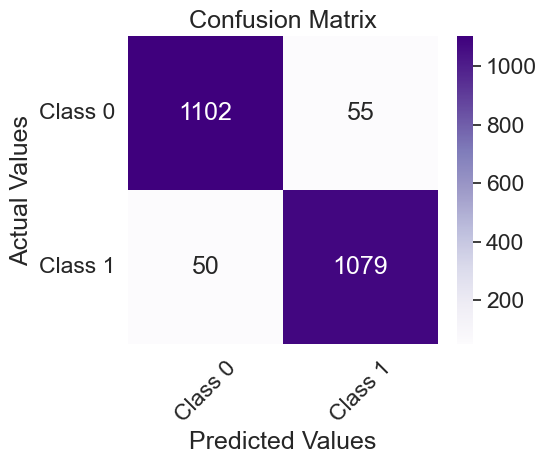

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming true_labels and predicted_labels are already defined

# Define class names for your binary classification
class_names = ['Class 0', 'Class 1']  # Replace with your actual class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.5)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=True, 
                 xticklabels=class_names, yticklabels=class_names)

# Labeling the axes
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names, rotation=0)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Show the plot
plt.title('Confusion Matrix')
plt.show()

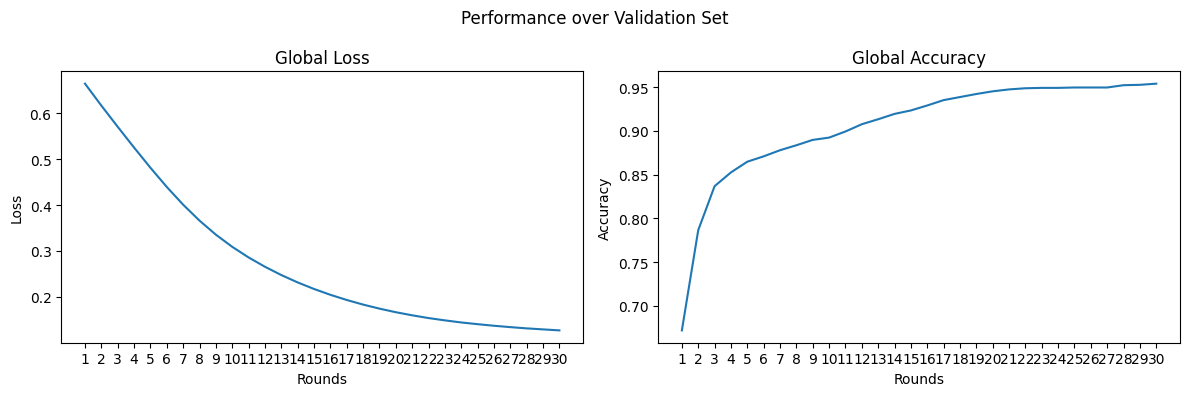

In [16]:
import matplotlib.pyplot as plt

plt.style.use('default')
plt.figure(figsize=(12, 4))
plt.suptitle("Performance over Validation Set")

# Plot for Global Loss
plt.subplot(121)
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.plot(range(1, len(global_loss_list_GRU) + 1), global_loss_list_GRU)
plt.xticks(range(1, len(global_loss_list_GRU) + 1))
plt.title("Global Loss")

# Plot for Global Accuracy
plt.subplot(122)
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.plot(range(1, len(global_accuracy_list_GRU) + 1), global_accuracy_list_GRU)
plt.xticks(range(1, len(global_accuracy_list_GRU) + 1))
plt.title("Global Accuracy")

plt.tight_layout()
plt.show()


**LSTM**

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tqdm import tqdm
import time

# Constants
BATCH_SIZE = 32
NUM_ROUNDS = 30
NUM_CLIENTS = 4  # Minimum must be 2
PROXIMAL_COEFFICIENT = 0.1  # Adjust this as needed
LOCAL_EPOCHS = 2  # Number of local epochs

# Declare lists for tracking global accuracy and loss
global_accuracy_list_LSTM = []
global_loss_list_LSTM = []

# Check the shape of X_train
print("X_train shape before reshaping:", X_train.shape)

# Reshape X_train if necessary
if len(X_train.shape) == 2:  # (samples, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, time_steps=1, features)

# Reshape X_test if necessary
if len(X_test.shape) == 2:  # (samples, features)
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # (samples, time_steps=1, features)

# Step 1: Define the Model Creation Function with LSTM
def create_model():
    cnn_model = Sequential()
    cnn_model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))  # First LSTM layer
    cnn_model.add(Dropout(0.5))  # Regularization
    cnn_model.add(LSTM(64))  # Second LSTM layer
    cnn_model.add(Dropout(0.5))  # Regularization
    cnn_model.add(Dense(1, activation='sigmoid'))  # Output layer (binary)
    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return cnn_model

# Initialize global model
global_model = create_model()

# Measure wall time and CPU time
start_time_wall = time.time()
start_time_cpu = time.process_time()

for round_num in range(NUM_ROUNDS):
    print(f'ROUND #{round_num + 1}/{NUM_ROUNDS} ')

    # Client preparation
    client_models = []
    for client_id in range(NUM_CLIENTS):
        client_model = create_model()
        client_model.set_weights(global_model.get_weights())  # Initialize with global model
        client_models.append(client_model)

    # Training on local data
    for client_id in tqdm(range(NUM_CLIENTS)):
        print(f'___________________Training CLIENT #{client_id + 1}')

        # Allocating data to each client
        start = client_id * (len(X_train) // NUM_CLIENTS)
        end = (client_id + 1) * (len(X_train) // NUM_CLIENTS)
        X_train_i = X_train[start:end]
        y_train_i = y_train[start:end]

        # Convert y_train_i to numpy and reshape it to (samples, 1)
        y_train_i = np.array(y_train_i).reshape(-1, 1)

        # Local training with FedProx
        for epoch in range(LOCAL_EPOCHS):  # Number of local epochs
            with tf.GradientTape() as tape:
                # Forward pass
                predictions = client_models[client_id](X_train_i, training=True)
                loss = tf.keras.losses.binary_crossentropy(y_train_i, predictions)

                # Compute the FedProx regularization term
                proximal_term = PROXIMAL_COEFFICIENT * tf.add_n([
                    tf.reduce_sum(tf.square(w - g))
                    for w, g in zip(client_models[client_id].trainable_weights, global_model.trainable_weights)
                ])
                
                total_loss = tf.reduce_mean(loss) + proximal_term
            # Compute gradients and apply updates
            grads = tape.gradient(total_loss, client_models[client_id].trainable_weights)
            client_models[client_id].optimizer.apply_gradients(zip(grads, client_models[client_id].trainable_weights))

    # Global Aggregation
    new_weights = [np.mean([client_models[i].get_weights()[layer] for i in range(NUM_CLIENTS)], axis=0) for layer in range(len(global_model.get_weights()))]
    global_model.set_weights(new_weights)

    # Evaluate the global model on training data
    loss, acc = global_model.evaluate(X_train, y_train, verbose=0)
    print(f'Global Train Loss: {loss}, Global Train Accuracy: {acc}')

    # Evaluate on X_test
    loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
    print(f'Global Validation Loss: {loss}, Global Validation Accuracy: {acc}\n_________________________________________________________')

    # Append the global loss and accuracy to their respective lists
    global_loss_list_LSTM.append(loss)
    global_accuracy_list_LSTM.append(acc)

# Measure end time for wall time
end_time_wall = time.time()
end_time_cpu = time.process_time()

# Calculate and print wall time and CPU time
wall_time = end_time_wall - start_time_wall
cpu_time = end_time_cpu - start_time_cpu

print(f'Total Wall Time: {wall_time:.2f} seconds')
print(f'Total CPU Time: {cpu_time:.2f} seconds')

# Optional: Save the final global model
# global_model.save("final_global_model_LSTM.keras")

# Print the final global loss and accuracy lists
print("Global Loss List (LSTM):", global_loss_list_LSTM)
print("Global Accuracy List (LSTM):", global_accuracy_list_LSTM)


X_train shape before reshaping: (9144, 1, 88)
ROUND #1/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  9.23it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00, 10.07it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]

Global Train Loss: 0.6826663613319397, Global Train Accuracy: 0.7707786560058594
Global Validation Loss: 0.6825247406959534, Global Validation Accuracy: 0.7834645509719849
_________________________________________________________
ROUND #2/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.64it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.11it/s]

___________________Training CLIENT #4


Global Train Loss: 0.6732028126716614, Global Train Accuracy: 0.8439413905143738
Global Validation Loss: 0.6727911829948425, Global Validation Accuracy: 0.8482064604759216
_________________________________________________________
ROUND #3/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  9.57it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.16it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4


Global Train Loss: 0.6628364324569702, Global Train Accuracy: 0.8634076714515686
Global Validation Loss: 0.6621274948120117, Global Validation Accuracy: 0.8683289885520935
_________________________________________________________
ROUND #4/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 13.24it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.81it/s]

___________________Training CLIENT #4
Global Train Loss: 0.6512365341186523, Global Train Accuracy: 0.8655949234962463
Global Validation Loss: 0.6502043008804321, Global Validation Accuracy: 0.8748906254768372
_________________________________________________________
ROUND #5/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.72it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.48it/s]

___________________Training CLIENT #4
Global Train Loss: 0.6381655931472778, Global Train Accuracy: 0.8653761744499207
Global Validation Loss: 0.6367807388305664, Global Validation Accuracy: 0.8766404390335083
_________________________________________________________
ROUND #6/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 12.26it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.38it/s]

___________________Training CLIENT #4
Global Train Loss: 0.6235594153404236, Global Train Accuracy: 0.8665791749954224
Global Validation Loss: 0.6217911243438721, Global Validation Accuracy: 0.8744531869888306
_________________________________________________________
ROUND #7/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 10.85it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.16it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.6074554920196533, Global Train Accuracy: 0.8664698004722595
Global Validation Loss: 0.6052780151367188, Global Validation Accuracy: 0.8766404390335083
_________________________________________________________
ROUND #8/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 12.28it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.49it/s]

___________________Training CLIENT #4
Global Train Loss: 0.590047299861908, Global Train Accuracy: 0.867016613483429
Global Validation Loss: 0.5874375104904175, Global Validation Accuracy: 0.8783901929855347
_________________________________________________________
ROUND #9/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 10.06it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]

Global Train Loss: 0.5715895891189575, Global Train Accuracy: 0.8663604259490967
Global Validation Loss: 0.568535327911377, Global Validation Accuracy: 0.8757655024528503
_________________________________________________________
ROUND #10/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 12.00it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.35it/s]

___________________Training CLIENT #4


Global Train Loss: 0.5523695349693298, Global Train Accuracy: 0.8659229874610901
Global Validation Loss: 0.5488570928573608, Global Validation Accuracy: 0.8753280639648438
_________________________________________________________
ROUND #11/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  9.53it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.56it/s]

___________________Training CLIENT #4
Global Train Loss: 0.5326828956604004, Global Train Accuracy: 0.8662511110305786
Global Validation Loss: 0.528712809085846, Global Validation Accuracy: 0.8757655024528503
_________________________________________________________
ROUND #12/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.21it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.97it/s]

___________________Training CLIENT #4


Global Train Loss: 0.5128666758537292, Global Train Accuracy: 0.8661417365074158
Global Validation Loss: 0.5084447264671326, Global Validation Accuracy: 0.8762030005455017
_________________________________________________________
ROUND #13/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.37it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.88it/s]

___________________Training CLIENT #4
Global Train Loss: 0.4931870698928833, Global Train Accuracy: 0.8665791749954224
Global Validation Loss: 0.4883267879486084, Global Validation Accuracy: 0.8762030005455017
_________________________________________________________
ROUND #14/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.16it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.45it/s]

___________________Training CLIENT #4
Global Train Loss: 0.473889023065567, Global Train Accuracy: 0.8669072389602661
Global Validation Loss: 0.4686090350151062, Global Validation Accuracy: 0.8770778775215149
_________________________________________________________
ROUND #15/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.86it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.62it/s]

___________________Training CLIENT #4
Global Train Loss: 0.45516034960746765, Global Train Accuracy: 0.8690944910049438
Global Validation Loss: 0.44948992133140564, Global Validation Accuracy: 0.8797025084495544
_________________________________________________________
ROUND #16/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  9.98it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.10it/s]

___________________Training CLIENT #4
Global Train Loss: 0.4371340870857239, Global Train Accuracy: 0.8707349300384521
Global Validation Loss: 0.43109312653541565, Global Validation Accuracy: 0.8840770125389099
_________________________________________________________
ROUND #17/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.68it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.08it/s]

___________________Training CLIENT #4


Global Train Loss: 0.4199009835720062, Global Train Accuracy: 0.8747812509536743
Global Validation Loss: 0.41351985931396484, Global Validation Accuracy: 0.8867016434669495
_________________________________________________________
ROUND #18/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 10.97it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.97it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.4035148024559021, Global Train Accuracy: 0.8780621290206909
Global Validation Loss: 0.3968297839164734, Global Validation Accuracy: 0.8884514570236206
_________________________________________________________
ROUND #19/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.28it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.64it/s]

___________________Training CLIENT #4


Global Train Loss: 0.3879651129245758, Global Train Accuracy: 0.8805774450302124
Global Validation Loss: 0.3810132145881653, Global Validation Accuracy: 0.8906386494636536
_________________________________________________________
ROUND #20/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 10.83it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.86it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.86it/s]

Global Train Loss: 0.3732227385044098, Global Train Accuracy: 0.8833114504814148
Global Validation Loss: 0.36601197719573975, Global Validation Accuracy: 0.8923884630203247
_________________________________________________________
ROUND #21/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.54it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.26it/s]

___________________Training CLIENT #4


Global Train Loss: 0.3592693507671356, Global Train Accuracy: 0.887139081954956
Global Validation Loss: 0.3518572449684143, Global Validation Accuracy: 0.8950130939483643
_________________________________________________________
ROUND #22/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.38it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.32it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4


Global Train Loss: 0.3460506796836853, Global Train Accuracy: 0.8893263339996338
Global Validation Loss: 0.33846187591552734, Global Validation Accuracy: 0.8967629075050354
_________________________________________________________
ROUND #23/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.82it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.86it/s]

___________________Training CLIENT #4
Global Train Loss: 0.3335444927215576, Global Train Accuracy: 0.8928259015083313
Global Validation Loss: 0.3258013129234314, Global Validation Accuracy: 0.8980752229690552
_________________________________________________________
ROUND #24/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  9.96it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.90it/s]

___________________Training CLIENT #4


Global Train Loss: 0.32167911529541016, Global Train Accuracy: 0.8961067199707031
Global Validation Loss: 0.31379830837249756, Global Validation Accuracy: 0.9050743579864502
_________________________________________________________
ROUND #25/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.23it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.04it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.88it/s]

Global Train Loss: 0.3104017972946167, Global Train Accuracy: 0.8989501595497131
Global Validation Loss: 0.30240973830223083, Global Validation Accuracy: 0.9072616100311279
_________________________________________________________
ROUND #26/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.65it/s]

___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.74it/s]

Global Train Loss: 0.29969483613967896, Global Train Accuracy: 0.9027777910232544
Global Validation Loss: 0.29160672426223755, Global Validation Accuracy: 0.9107611775398254
_________________________________________________________
ROUND #27/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.44it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.49it/s]

___________________Training CLIENT #4
Global Train Loss: 0.28947845101356506, Global Train Accuracy: 0.905402421951294
Global Validation Loss: 0.2813035845756531, Global Validation Accuracy: 0.913385808467865
_________________________________________________________
ROUND #28/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.42it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.91it/s]

___________________Training CLIENT #4


Global Train Loss: 0.27977287769317627, Global Train Accuracy: 0.9074802994728088
Global Validation Loss: 0.27152013778686523, Global Validation Accuracy: 0.9164479374885559
_________________________________________________________
ROUND #29/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.98it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.46it/s]

___________________Training CLIENT #4


Global Train Loss: 0.27051904797554016, Global Train Accuracy: 0.9104330539703369
Global Validation Loss: 0.26215875148773193, Global Validation Accuracy: 0.9195100665092468
_________________________________________________________
ROUND #30/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 11.68it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.28it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4


Global Train Loss: 0.2617453336715698, Global Train Accuracy: 0.9144794344902039
Global Validation Loss: 0.2532811760902405, Global Validation Accuracy: 0.9208223819732666
_________________________________________________________
Total Wall Time: 93.02 seconds
Total CPU Time: 25.38 seconds
Global Loss List (LSTM): [0.6825247406959534, 0.6727911829948425, 0.6621274948120117, 0.6502043008804321, 0.6367807388305664, 0.6217911243438721, 0.6052780151367188, 0.5874375104904175, 0.568535327911377, 0.5488570928573608, 0.528712809085846, 0.5084447264671326, 0.4883267879486084, 0.4686090350151062, 0.44948992133140564, 0.43109312653541565, 0.41351985931396484, 0.3968297839164734, 0.3810132145881653, 0.36601197719573975, 0.3518572449684143, 0.33846187591552734, 0.3258013129234314, 0.31379830837249756, 0.30240973830223083, 0.29160672426223755, 0.2813035845756531, 0.27152013778686523, 0.26215875148773193, 0.2532811760902405]
Global Accuracy List (LSTM): [0.7834645509719849, 0.8482064604759216, 0.868

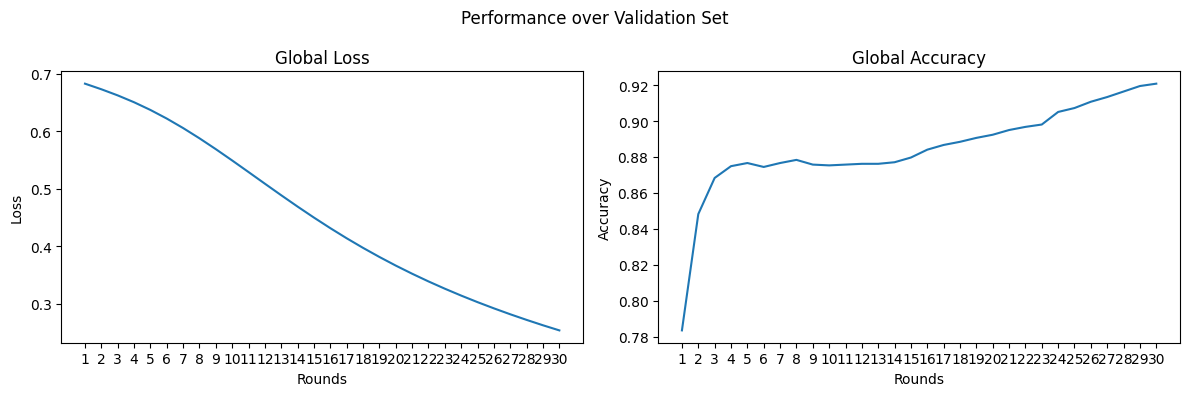

In [18]:
import matplotlib.pyplot as plt

plt.style.use('default')
plt.figure(figsize=(12, 4))
plt.suptitle("Performance over Validation Set")

# Plot for Global Loss
plt.subplot(121)
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.plot(range(1, len(global_loss_list_LSTM) + 1), global_loss_list_LSTM)
plt.xticks(range(1, len(global_loss_list_LSTM) + 1))
plt.title("Global Loss")

# Plot for Global Accuracy
plt.subplot(122)
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.plot(range(1, len(global_accuracy_list_LSTM) + 1), global_accuracy_list_LSTM)
plt.xticks(range(1, len(global_accuracy_list_LSTM) + 1))
plt.title("Global Accuracy")

plt.tight_layout()
plt.show()


In [19]:
train_loss, train_acc = global_model.evaluate(X_train, y_train)
print(f"Global Train Accuracy : {train_acc}")
print(f"Global Train Loss : {train_loss}")


val_loss, val_acc = global_model.evaluate(X_test, y_test)
print(f"Global Validation Accuracy : {val_acc}")
print(f"Global Validation Loss : {val_loss}")
     

286/286 [==============================] - 1s 3ms/step - loss: 0.2617 - accuracy: 0.9145
Global Train Accuracy : 0.9144794344902039
Global Train Loss : 0.2617453336715698
72/72 [==============================] - 0s 3ms/step - loss: 0.2533 - accuracy: 0.9208
Global Validation Accuracy : 0.9208223819732666
Global Validation Loss : 0.2532811760902405


In [20]:
import tensorflow as tf
from sklearn.metrics import classification_report

# Generate predictions
predictions = global_model.predict(X_test)

# Convert probabilities to binary labels
predicted_labels = (predictions > 0.5).astype("int32").flatten()  # Convert to 1D array

# Check the shape of y_test
print("y_test shape:", y_test.shape)

# If y_test is one-hot encoded, convert it to binary labels
if len(y_test.shape) == 2 and y_test.shape[1] == 2:  # Assuming two classes
    true_labels = tf.argmax(y_test, axis=1).numpy()  # Convert to 1D array
else:
    true_labels = y_test  # Already 1D array

# Print classification metrics
class_report = classification_report(true_labels, predicted_labels, digits=6, zero_division=0)
print(class_report)

72/72 [==============================] - 1s 2ms/step
y_test shape: (2286,)
              precision    recall  f1-score   support

           0   0.916382  0.928263  0.922284      1157
           1   0.925494  0.913198  0.919305      1129

    accuracy                       0.920822      2286
   macro avg   0.920938  0.920730  0.920794      2286
weighted avg   0.920882  0.920822  0.920813      2286



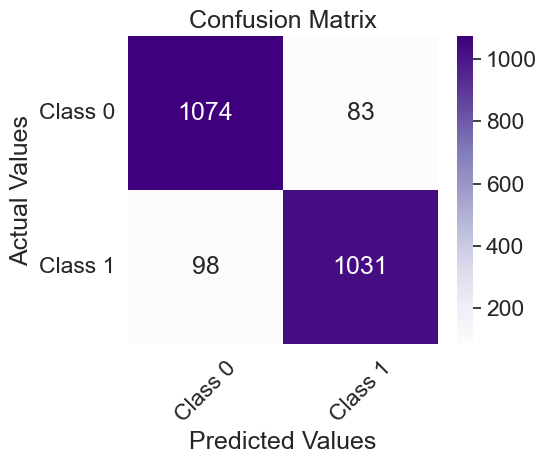

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming true_labels and predicted_labels are already defined

# Define class names for your binary classification
class_names = ['Class 0', 'Class 1']  # Replace with your actual class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.5)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=True, 
                 xticklabels=class_names, yticklabels=class_names)

# Labeling the axes
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names, rotation=0)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Show the plot
plt.title('Confusion Matrix')
plt.show()

**BiLSTM**

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tqdm import tqdm
import time

# Constants
BATCH_SIZE = 32
NUM_ROUNDS = 30
NUM_CLIENTS = 4  # Minimum must be 2
PROXIMAL_COEFFICIENT = 0.1  # Adjust this as needed
LOCAL_EPOCHS = 2  # Number of local epochs

# Declare lists for tracking global accuracy and loss
global_accuracy_list_BiLSTM = []
global_loss_list_BiLSTM = []

# Check the shape of X_train
print("X_train shape before reshaping:", X_train.shape)

# Reshape X_train if necessary
if len(X_train.shape) == 2:  # (samples, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, time_steps=1, features)

# Reshape X_test if necessary
if len(X_test.shape) == 2:  # (samples, features)
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # (samples, time_steps=1, features)

# Step 1: Define the Model Creation Function with BiLSTM
def create_model():
    cnn_model = Sequential()
    cnn_model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))  # First BiLSTM layer
    cnn_model.add(Dropout(0.5))  # Regularization
    cnn_model.add(Bidirectional(LSTM(64)))  # Second BiLSTM layer
    cnn_model.add(Dropout(0.5))  # Regularization
    cnn_model.add(Dense(1, activation='sigmoid'))  # Output layer (binary)
    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return cnn_model

# Initialize global model
global_model = create_model()

# Measure wall time and CPU time
start_time_wall = time.time()
start_time_cpu = time.process_time()

for round_num in range(NUM_ROUNDS):
    print(f'ROUND #{round_num + 1}/{NUM_ROUNDS} ')

    # Client preparation
    client_models = []
    for client_id in range(NUM_CLIENTS):
        client_model = create_model()
        client_model.set_weights(global_model.get_weights())  # Initialize with global model
        client_models.append(client_model)

    # Training on local data
    for client_id in tqdm(range(NUM_CLIENTS)):
        print(f'___________________Training CLIENT #{client_id + 1}')

        # Allocating data to each client
        start = client_id * (len(X_train) // NUM_CLIENTS)
        end = (client_id + 1) * (len(X_train) // NUM_CLIENTS)
        X_train_i = X_train[start:end]
        y_train_i = y_train[start:end]

        # Convert y_train_i to numpy and reshape it to (samples, 1)
        y_train_i = np.array(y_train_i).reshape(-1, 1)

        # Local training with FedProx
        for epoch in range(LOCAL_EPOCHS):  # Number of local epochs
            with tf.GradientTape() as tape:
                # Forward pass
                predictions = client_models[client_id](X_train_i, training=True)
                loss = tf.keras.losses.binary_crossentropy(y_train_i, predictions)

                # Compute the FedProx regularization term
                proximal_term = PROXIMAL_COEFFICIENT * tf.add_n([
                    tf.reduce_sum(tf.square(w - g))
                    for w, g in zip(client_models[client_id].trainable_weights, global_model.trainable_weights)
                ])
                
                total_loss = tf.reduce_mean(loss) + proximal_term
            # Compute gradients and apply updates
            grads = tape.gradient(total_loss, client_models[client_id].trainable_weights)
            client_models[client_id].optimizer.apply_gradients(zip(grads, client_models[client_id].trainable_weights))

    # Global Aggregation
    new_weights = [np.mean([client_models[i].get_weights()[layer] for i in range(NUM_CLIENTS)], axis=0) for layer in range(len(global_model.get_weights()))]
    global_model.set_weights(new_weights)

    # Evaluate the global model on training data
    loss, acc = global_model.evaluate(X_train, y_train, verbose=0)
    print(f'Global Train Loss: {loss}, Global Train Accuracy: {acc}')

    # Evaluate on X_test
    loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
    print(f'Global Validation Loss: {loss}, Global Validation Accuracy: {acc}\n_________________________________________________________')

    # Append the global loss and accuracy to their respective lists
    global_loss_list_BiLSTM.append(loss)
    global_accuracy_list_BiLSTM.append(acc)

# Measure end time for wall time
end_time_wall = time.time()
end_time_cpu = time.process_time()

# Calculate and print wall time and CPU time
wall_time = end_time_wall - start_time_wall
cpu_time = end_time_cpu - start_time_cpu

print(f'Total Wall Time: {wall_time:.2f} seconds')
print(f'Total CPU Time: {cpu_time:.2f} seconds')

# Optional: Save the final global model
# global_model.save("final_global_model_BiLSTM.keras")

# Print the final global loss and accuracy lists
print("Global Loss List (BiLSTM):", global_loss_list_BiLSTM)
print("Global Accuracy List (BiLSTM):", global_accuracy_list_BiLSTM)


X_train shape before reshaping: (9144, 1, 88)
ROUND #1/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.54it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.79it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.65it/s]

Global Train Loss: 0.6798033118247986, Global Train Accuracy: 0.7548118829727173
Global Validation Loss: 0.6795205473899841, Global Validation Accuracy: 0.7729659080505371
_________________________________________________________
ROUND #2/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  5.80it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.29it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.21it/s]

Global Train Loss: 0.6589564085006714, Global Train Accuracy: 0.8328958749771118
Global Validation Loss: 0.6581887602806091, Global Validation Accuracy: 0.834645688533783
_________________________________________________________
ROUND #3/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.85it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.67it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.70it/s]

Global Train Loss: 0.6357889175415039, Global Train Accuracy: 0.8494094610214233
Global Validation Loss: 0.6344771385192871, Global Validation Accuracy: 0.8573928475379944
_________________________________________________________
ROUND #4/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.73it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.44it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.54it/s]

Global Train Loss: 0.6095375418663025, Global Train Accuracy: 0.8553149700164795
Global Validation Loss: 0.6076089143753052, Global Validation Accuracy: 0.8622047305107117
_________________________________________________________
ROUND #5/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.38it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.34it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.51it/s]

Global Train Loss: 0.580319344997406, Global Train Accuracy: 0.8559711575508118
Global Validation Loss: 0.5777151584625244, Global Validation Accuracy: 0.8643919229507446
_________________________________________________________
ROUND #6/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.48it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.60it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60it/s]

Global Train Loss: 0.5488368272781372, Global Train Accuracy: 0.8570647239685059
Global Validation Loss: 0.5455156564712524, Global Validation Accuracy: 0.8692038655281067
_________________________________________________________
ROUND #7/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  5.82it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.49it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.44it/s]

Global Train Loss: 0.5161861777305603, Global Train Accuracy: 0.8591426014900208
Global Validation Loss: 0.5121392011642456, Global Validation Accuracy: 0.8687664270401001
_________________________________________________________
ROUND #8/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.23it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.29it/s]

___________________Training CLIENT #3



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.34it/s]

___________________Training CLIENT #4
Global Train Loss: 0.48363447189331055, Global Train Accuracy: 0.8603456020355225
Global Validation Loss: 0.478861927986145, Global Validation Accuracy: 0.8696413040161133
_________________________________________________________
ROUND #9/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.44it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.01it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]

Global Train Loss: 0.4523358643054962, Global Train Accuracy: 0.86384516954422
Global Validation Loss: 0.44687169790267944, Global Validation Accuracy: 0.8718284964561462
_________________________________________________________
ROUND #10/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.80it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.86it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.86it/s]

Global Train Loss: 0.42312315106391907, Global Train Accuracy: 0.8663604259490967
Global Validation Loss: 0.4169944226741791, Global Validation Accuracy: 0.8731408715248108
_________________________________________________________
ROUND #11/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.83it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.35it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12it/s]

Global Train Loss: 0.39640089869499207, Global Train Accuracy: 0.8688757419586182
Global Validation Loss: 0.3896627724170685, Global Validation Accuracy: 0.8770778775215149
_________________________________________________________
ROUND #12/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.57it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.35it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.33it/s]

Global Train Loss: 0.3723011612892151, Global Train Accuracy: 0.8728127479553223
Global Validation Loss: 0.36501654982566833, Global Validation Accuracy: 0.8814523220062256
_________________________________________________________
ROUND #13/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.80it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.92it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87it/s]

Global Train Loss: 0.35062894225120544, Global Train Accuracy: 0.8775153160095215
Global Validation Loss: 0.3428909182548523, Global Validation Accuracy: 0.8836395740509033
_________________________________________________________
ROUND #14/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.32it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.49it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.53it/s]

Global Train Loss: 0.33116498589515686, Global Train Accuracy: 0.8830927610397339
Global Validation Loss: 0.3230445981025696, Global Validation Accuracy: 0.8915135860443115
_________________________________________________________
ROUND #15/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.95it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.10it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.93it/s]

Global Train Loss: 0.3135495185852051, Global Train Accuracy: 0.88899827003479
Global Validation Loss: 0.305116206407547, Global Validation Accuracy: 0.8967629075050354
_________________________________________________________
ROUND #16/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.95it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.46it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]

Global Train Loss: 0.2975698709487915, Global Train Accuracy: 0.8939195275306702
Global Validation Loss: 0.2888987958431244, Global Validation Accuracy: 0.904199481010437
_________________________________________________________
ROUND #17/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.67it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.23it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.17it/s]

Global Train Loss: 0.28294438123703003, Global Train Accuracy: 0.9005905389785767
Global Validation Loss: 0.27408653497695923, Global Validation Accuracy: 0.9107611775398254
_________________________________________________________
ROUND #18/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.28it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.99it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.09it/s]

Global Train Loss: 0.2694893479347229, Global Train Accuracy: 0.9048556685447693
Global Validation Loss: 0.26047149300575256, Global Validation Accuracy: 0.9146981835365295
_________________________________________________________
ROUND #19/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.57it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.59it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.53it/s]

Global Train Loss: 0.25709301233291626, Global Train Accuracy: 0.90923011302948
Global Validation Loss: 0.2479476034641266, Global Validation Accuracy: 0.9199475049972534
_________________________________________________________
ROUND #20/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.64it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  7.05it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.05it/s]

Global Train Loss: 0.24568217992782593, Global Train Accuracy: 0.9137139320373535
Global Validation Loss: 0.23639243841171265, Global Validation Accuracy: 0.9238845109939575
_________________________________________________________
ROUND #21/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.82it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.57it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.78it/s]

Global Train Loss: 0.23518767952919006, Global Train Accuracy: 0.9175415635108948
Global Validation Loss: 0.22578375041484833, Global Validation Accuracy: 0.9278215169906616
_________________________________________________________
ROUND #22/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.33it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.18it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.38it/s]

Global Train Loss: 0.22552432119846344, Global Train Accuracy: 0.9211505055427551
Global Validation Loss: 0.21597860753536224, Global Validation Accuracy: 0.9286963939666748
_________________________________________________________
ROUND #23/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.26it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.22it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.34it/s]

Global Train Loss: 0.2166597843170166, Global Train Accuracy: 0.9237751364707947
Global Validation Loss: 0.20693624019622803, Global Validation Accuracy: 0.9313210844993591
_________________________________________________________
ROUND #24/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.02it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.65it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.67it/s]

Global Train Loss: 0.20856040716171265, Global Train Accuracy: 0.9281495809555054
Global Validation Loss: 0.19862885773181915, Global Validation Accuracy: 0.9348206520080566
_________________________________________________________
ROUND #25/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.18it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.78it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.83it/s]

Global Train Loss: 0.2011842280626297, Global Train Accuracy: 0.931430459022522
Global Validation Loss: 0.19101883471012115, Global Validation Accuracy: 0.937445342540741
_________________________________________________________
ROUND #26/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.02it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.61it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.74it/s]

Global Train Loss: 0.1944585144519806, Global Train Accuracy: 0.9339457750320435
Global Validation Loss: 0.18407222628593445, Global Validation Accuracy: 0.9396325349807739
_________________________________________________________
ROUND #27/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.70it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.88it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.92it/s]

Global Train Loss: 0.1883162409067154, Global Train Accuracy: 0.9364610910415649
Global Validation Loss: 0.17766737937927246, Global Validation Accuracy: 0.9418197870254517
_________________________________________________________
ROUND #28/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.05it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  4.14it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.45it/s]

Global Train Loss: 0.18272586166858673, Global Train Accuracy: 0.9372265934944153
Global Validation Loss: 0.1718316376209259, Global Validation Accuracy: 0.9444444179534912
_________________________________________________________
ROUND #29/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  7.41it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.53it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.91it/s]

Global Train Loss: 0.17763163149356842, Global Train Accuracy: 0.9388670325279236
Global Validation Loss: 0.1664288491010666, Global Validation Accuracy: 0.946631669998169
_________________________________________________________
ROUND #30/30 


 25%|█████████████████████                                                               | 1/4 [00:00<00:00,  6.68it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00,  6.52it/s]

___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]

Global Train Loss: 0.1729881465435028, Global Train Accuracy: 0.940398097038269
Global Validation Loss: 0.16154548525810242, Global Validation Accuracy: 0.946631669998169
_________________________________________________________
Total Wall Time: 165.79 seconds
Total CPU Time: 54.34 seconds
Global Loss List (BiLSTM): [0.6795205473899841, 0.6581887602806091, 0.6344771385192871, 0.6076089143753052, 0.5777151584625244, 0.5455156564712524, 0.5121392011642456, 0.478861927986145, 0.44687169790267944, 0.4169944226741791, 0.3896627724170685, 0.36501654982566833, 0.3428909182548523, 0.3230445981025696, 0.305116206407547, 0.2888987958431244, 0.27408653497695923, 0.26047149300575256, 0.2479476034641266, 0.23639243841171265, 0.22578375041484833, 0.21597860753536224, 0.20693624019622803, 0.19862885773181915, 0.19101883471012115, 0.18407222628593445, 0.17766737937927246, 0.1718316376209259, 0.1664288491010666, 0.16154548525810242]
Global Accuracy List (BiLSTM): [0.7729659080505371, 0.834645688533783,

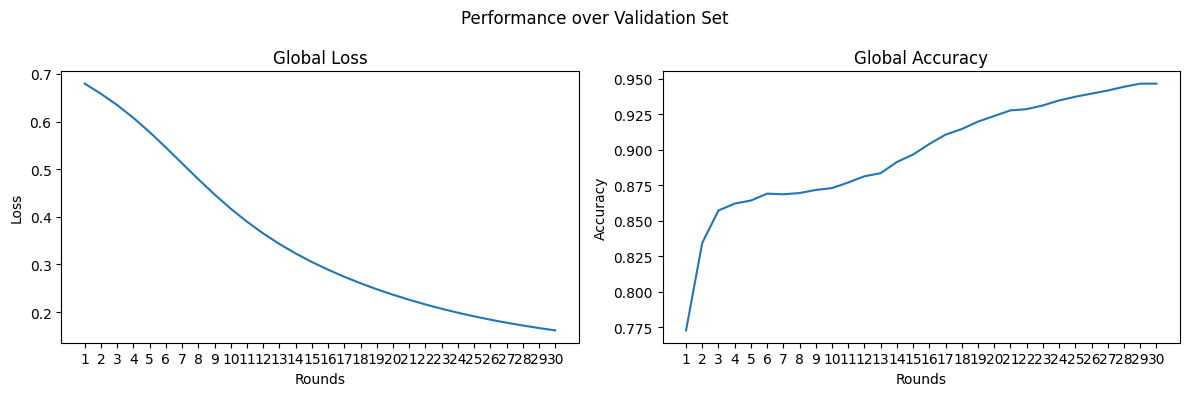

In [23]:
import matplotlib.pyplot as plt

plt.style.use('default')
plt.figure(figsize=(12, 4))
plt.suptitle("Performance over Validation Set")

# Plot for Global Loss
plt.subplot(121)
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.plot(range(1, len(global_loss_list_BiLSTM) + 1), global_loss_list_BiLSTM)
plt.xticks(range(1, len(global_loss_list_BiLSTM) + 1))
plt.title("Global Loss")

# Plot for Global Accuracy
plt.subplot(122)
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.plot(range(1, len(global_accuracy_list_BiLSTM) + 1), global_accuracy_list_BiLSTM)
plt.xticks(range(1, len(global_accuracy_list_BiLSTM) + 1))
plt.title("Global Accuracy")

plt.tight_layout()
plt.show()


In [24]:
train_loss, train_acc = global_model.evaluate(X_train, y_train)
print(f"Global Train Accuracy : {train_acc}")
print(f"Global Train Loss : {train_loss}")


val_loss, val_acc = global_model.evaluate(X_test, y_test)
print(f"Global Validation Accuracy : {val_acc}")
print(f"Global Validation Loss : {val_loss}")
     

286/286 [==============================] - 1s 4ms/step - loss: 0.1730 - accuracy: 0.9404
Global Train Accuracy : 0.940398097038269
Global Train Loss : 0.1729881465435028
72/72 [==============================] - 0s 3ms/step - loss: 0.1615 - accuracy: 0.9466
Global Validation Accuracy : 0.946631669998169
Global Validation Loss : 0.16154548525810242


In [25]:
import tensorflow as tf
from sklearn.metrics import classification_report

# Generate predictions
predictions = global_model.predict(X_test)

# Convert probabilities to binary labels
predicted_labels = (predictions > 0.5).astype("int32").flatten()  # Convert to 1D array

# Check the shape of y_test
print("y_test shape:", y_test.shape)

# If y_test is one-hot encoded, convert it to binary labels
if len(y_test.shape) == 2 and y_test.shape[1] == 2:  # Assuming two classes
    true_labels = tf.argmax(y_test, axis=1).numpy()  # Convert to 1D array
else:
    true_labels = y_test  # Already 1D array

# Print classification metrics
class_report = classification_report(true_labels, predicted_labels, digits=6, zero_division=0)
print(class_report)

72/72 [==============================] - 1s 3ms/step
y_test shape: (2286,)
              precision    recall  f1-score   support

           0   0.942686  0.952463  0.947549      1157
           1   0.950761  0.940655  0.945681      1129

    accuracy                       0.946632      2286
   macro avg   0.946724  0.946559  0.946615      2286
weighted avg   0.946674  0.946632  0.946627      2286



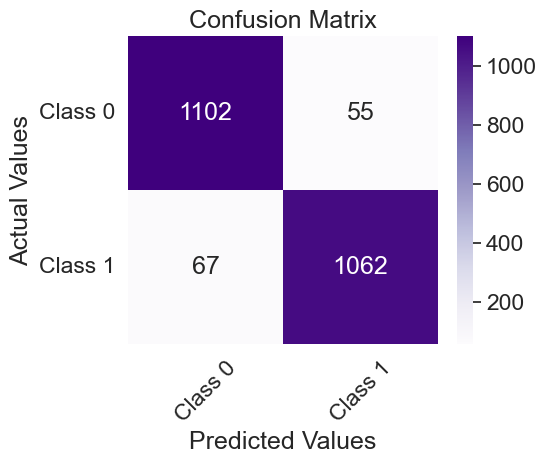

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming true_labels and predicted_labels are already defined

# Define class names for your binary classification
class_names = ['Class 0', 'Class 1']  # Replace with your actual class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.5)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=True, 
                 xticklabels=class_names, yticklabels=class_names)

# Labeling the axes
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names, rotation=0)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Show the plot
plt.title('Confusion Matrix')
plt.show()

**1DCNN**

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tqdm import tqdm
import time

# Constants
BATCH_SIZE = 32
NUM_ROUNDS = 30
NUM_CLIENTS = 4  # Minimum must be 2
PROXIMAL_COEFFICIENT = 0.1  # Adjust this as needed
LOCAL_EPOCHS = 2  # Number of local epochs

# Declare lists for tracking global accuracy and loss
global_accuracy_list_CNN = []
global_loss_list_CNN = []

# Check the shape of X_train
print("X_train shape before reshaping:", X_train.shape)

# Reshape X_train to be 2D (samples, features)
if len(X_train.shape) == 3:  # (samples, time_steps, features)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[2])  # (samples, features)

# Reshape X_test to be 2D (samples, features)
if len(X_test.shape) == 3:  # (samples, time_steps, features)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])  # (samples, features)

# Step 1: Define the Model Creation Function with Your 1D CNN
def create_model():
    cnn_model = Sequential()
    cnn_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # Input layer
    cnn_model.add(Dropout(0.5))  # Regularization
    cnn_model.add(Dense(32, activation='relu'))  # Hidden layer
    cnn_model.add(Dense(1, activation='sigmoid'))  # Output layer (binary)
    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return cnn_model

# Initialize global model
global_model = create_model()

# Measure wall time and CPU time
start_time_wall = time.time()
start_time_cpu = time.process_time()

for round_num in range(NUM_ROUNDS):
    print(f'ROUND #{round_num + 1}/{NUM_ROUNDS} ')

    # Client preparation
    client_models = []
    for client_id in range(NUM_CLIENTS):
        client_model = create_model()
        client_model.set_weights(global_model.get_weights())  # Initialize with global model
        client_models.append(client_model)

    # Training on local data
    for client_id in tqdm(range(NUM_CLIENTS)):
        print(f'___________________Training CLIENT #{client_id + 1}')

        # Allocating data to each client
        start = client_id * (len(X_train) // NUM_CLIENTS)
        end = (client_id + 1) * (len(X_train) // NUM_CLIENTS)
        X_train_i = X_train[start:end]
        y_train_i = y_train[start:end]

        # Convert y_train_i to numpy if needed
        y_train_i = np.array(y_train_i).reshape(-1, 1)

        # Local training with FedProx
        for epoch in range(LOCAL_EPOCHS):  # Number of local epochs
            with tf.GradientTape() as tape:
                # Forward pass
                predictions = client_models[client_id](X_train_i, training=True)
                loss = tf.keras.losses.binary_crossentropy(y_train_i, predictions)

                # Compute the FedProx regularization term
                proximal_term = PROXIMAL_COEFFICIENT * tf.add_n([
                    tf.reduce_sum(tf.square(w - g))
                    for w, g in zip(client_models[client_id].trainable_weights, global_model.trainable_weights)
                ])
                
                total_loss = tf.reduce_mean(loss) + proximal_term
            # Compute gradients and apply updates
            grads = tape.gradient(total_loss, client_models[client_id].trainable_weights)
            client_models[client_id].optimizer.apply_gradients(zip(grads, client_models[client_id].trainable_weights))

    # Global Aggregation
    new_weights = [np.mean([client_models[i].get_weights()[layer] for i in range(NUM_CLIENTS)], axis=0) for layer in range(len(global_model.get_weights()))]
    global_model.set_weights(new_weights)

    # Evaluate the global model on training data
    loss, acc = global_model.evaluate(X_train, y_train, verbose=0)
    print(f'Global Train Loss: {loss}, Global Train Accuracy: {acc}')

    # Evaluate on X_test
    loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
    print(f'Global Validation Loss: {loss}, Global Validation Accuracy: {acc}\n_________________________________________________________')

    # Append the global loss and accuracy to their respective lists
    global_loss_list_CNN.append(loss)
    global_accuracy_list_CNN.append(acc)

# Measure end time for wall time
end_time_wall = time.time()
end_time_cpu = time.process_time()

# Calculate and print wall time and CPU time
wall_time = end_time_wall - start_time_wall
cpu_time = end_time_cpu - start_time_cpu

print(f'Total Wall Time: {wall_time:.2f} seconds')
print(f'Total CPU Time: {cpu_time:.2f} seconds')

# Optional: Save the final global model
# global_model.save("final_global_model_CNN.keras")

# Print the final global loss and accuracy lists
print("Global Loss List (CNN):", global_loss_list_CNN)
print("Global Accuracy List (CNN):", global_accuracy_list_CNN)

X_train shape before reshaping: (9144, 88)
ROUND #1/30 


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

___________________Training CLIENT #1



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.85it/s]

___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.6047524809837341, Global Train Accuracy: 0.6780402660369873
Global Validation Loss: 0.5942834615707397, Global Validation Accuracy: 0.6758530139923096
_________________________________________________________
ROUND #2/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.59it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.531193196773529, Global Train Accuracy: 0.784339427947998
Global Validation Loss: 0.5204281210899353, Global Validation Accuracy: 0.7882764935493469
_________________________________________________________
ROUND #3/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.40it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.4710344076156616, Global Train Accuracy: 0.8437226414680481
Global Validation Loss: 0.46058011054992676, Global Validation Accuracy: 0.8482064604759216
_________________________________________________________
ROUND #4/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.28it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.4213113486766815, Global Train Accuracy: 0.8675634264945984
Global Validation Loss: 0.4112725853919983, Global Validation Accuracy: 0.8766404390335083
_________________________________________________________
ROUND #5/30 


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00, 22.64it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.49it/s]

Global Train Loss: 0.3795878291130066, Global Train Accuracy: 0.8812335729598999
Global Validation Loss: 0.36967965960502625, Global Validation Accuracy: 0.890201210975647
_________________________________________________________
ROUND #6/30 


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00, 21.61it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.21it/s]

Global Train Loss: 0.3444223701953888, Global Train Accuracy: 0.8915135860443115
Global Validation Loss: 0.334328293800354, Global Validation Accuracy: 0.8976377844810486
_________________________________________________________
ROUND #7/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.56it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.3147689700126648, Global Train Accuracy: 0.8993875980377197
Global Validation Loss: 0.3042982220649719, Global Validation Accuracy: 0.9028871655464172
_________________________________________________________
ROUND #8/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.56it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.28941068053245544, Global Train Accuracy: 0.9055117964744568
Global Validation Loss: 0.2784499526023865, Global Validation Accuracy: 0.9103237390518188
_________________________________________________________
ROUND #9/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.06it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.26783204078674316, Global Train Accuracy: 0.9096675515174866
Global Validation Loss: 0.2566911578178406, Global Validation Accuracy: 0.9138232469558716
_________________________________________________________
ROUND #10/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.37it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.24974499642848969, Global Train Accuracy: 0.913385808467865
Global Validation Loss: 0.23844072222709656, Global Validation Accuracy: 0.9195100665092468
_________________________________________________________
ROUND #11/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.07it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.23386695981025696, Global Train Accuracy: 0.9187445044517517
Global Validation Loss: 0.22242195904254913, Global Validation Accuracy: 0.9225721955299377
_________________________________________________________
ROUND #12/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.00it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.22050030529499054, Global Train Accuracy: 0.9222440719604492
Global Validation Loss: 0.20893314480781555, Global Validation Accuracy: 0.9260717630386353
_________________________________________________________
ROUND #13/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.50it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.20874753594398499, Global Train Accuracy: 0.9262904524803162
Global Validation Loss: 0.19720444083213806, Global Validation Accuracy: 0.9278215169906616
_________________________________________________________
ROUND #14/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.46it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.19865189492702484, Global Train Accuracy: 0.9298993945121765
Global Validation Loss: 0.18695233762264252, Global Validation Accuracy: 0.9335083365440369
_________________________________________________________
ROUND #15/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 18.26it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.08it/s]

Global Train Loss: 0.19004885852336884, Global Train Accuracy: 0.9319772720336914
Global Validation Loss: 0.17856304347515106, Global Validation Accuracy: 0.9352580904960632
_________________________________________________________
ROUND #16/30 


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.95it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4


Global Train Loss: 0.1822161078453064, Global Train Accuracy: 0.9352580904960632
Global Validation Loss: 0.17089231312274933, Global Validation Accuracy: 0.937445342540741
_________________________________________________________
ROUND #17/30 


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00, 20.62it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.95it/s]

Global Train Loss: 0.17561125755310059, Global Train Accuracy: 0.937554657459259
Global Validation Loss: 0.16423651576042175, Global Validation Accuracy: 0.9422572255134583
_________________________________________________________
ROUND #18/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.31it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.16976475715637207, Global Train Accuracy: 0.9389764070510864
Global Validation Loss: 0.1585477739572525, Global Validation Accuracy: 0.9444444179534912
_________________________________________________________
ROUND #19/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.94it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.16473591327667236, Global Train Accuracy: 0.9408355355262756
Global Validation Loss: 0.1535501629114151, Global Validation Accuracy: 0.9448819160461426
_________________________________________________________
ROUND #20/30 


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 18.43it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 20.75it/s]

Global Train Loss: 0.16021162271499634, Global Train Accuracy: 0.9419291615486145
Global Validation Loss: 0.14926598966121674, Global Validation Accuracy: 0.9470691084861755
_________________________________________________________
ROUND #21/30 


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00, 22.08it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.62it/s]

Global Train Loss: 0.1559400111436844, Global Train Accuracy: 0.9423666000366211
Global Validation Loss: 0.1450112909078598, Global Validation Accuracy: 0.9496937990188599
_________________________________________________________
ROUND #22/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.72it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.15265235304832458, Global Train Accuracy: 0.9431321024894714
Global Validation Loss: 0.14175337553024292, Global Validation Accuracy: 0.9510061144828796
_________________________________________________________
ROUND #23/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.40it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.1496022641658783, Global Train Accuracy: 0.9442257285118103
Global Validation Loss: 0.138886496424675, Global Validation Accuracy: 0.9514435529708862
_________________________________________________________
ROUND #24/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.66it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.14698220789432526, Global Train Accuracy: 0.9453193545341492
Global Validation Loss: 0.13645339012145996, Global Validation Accuracy: 0.953630805015564
_________________________________________________________
ROUND #25/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.07it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.14446870982646942, Global Train Accuracy: 0.9461942315101624
Global Validation Loss: 0.13433198630809784, Global Validation Accuracy: 0.9545056819915771
_________________________________________________________
ROUND #26/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.40it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.1421646624803543, Global Train Accuracy: 0.946631669998169
Global Validation Loss: 0.1324131190776825, Global Validation Accuracy: 0.9558179974555969
_________________________________________________________
ROUND #27/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 25.43it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.13984286785125732, Global Train Accuracy: 0.9475065469741821
Global Validation Loss: 0.13051767647266388, Global Validation Accuracy: 0.9562554955482483
_________________________________________________________
ROUND #28/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 26.31it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.1379295438528061, Global Train Accuracy: 0.9481627345085144
Global Validation Loss: 0.12891258299350739, Global Validation Accuracy: 0.9562554955482483
_________________________________________________________
ROUND #29/30 


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:00<00:00, 24.04it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.98it/s]

Global Train Loss: 0.1361193060874939, Global Train Accuracy: 0.9487095475196838
Global Validation Loss: 0.127553790807724, Global Validation Accuracy: 0.9566929340362549
_________________________________________________________
ROUND #30/30 



00%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.81it/s]

___________________Training CLIENT #1
___________________Training CLIENT #2
___________________Training CLIENT #3
___________________Training CLIENT #4
Global Train Loss: 0.13472220301628113, Global Train Accuracy: 0.9492563605308533
Global Validation Loss: 0.12677909433841705, Global Validation Accuracy: 0.9571303725242615
_________________________________________________________
Total Wall Time: 28.40 seconds
Total CPU Time: 4.44 seconds
Global Loss List (CNN): [0.5942834615707397, 0.5204281210899353, 0.46058011054992676, 0.4112725853919983, 0.36967965960502625, 0.334328293800354, 0.3042982220649719, 0.2784499526023865, 0.2566911578178406, 0.23844072222709656, 0.22242195904254913, 0.20893314480781555, 0.19720444083213806, 0.18695233762264252, 0.17856304347515106, 0.17089231312274933, 0.16423651576042175, 0.1585477739572525, 0.1535501629114151, 0.14926598966121674, 0.1450112909078598, 0.14175337553024292, 0.138886496424675, 0.13645339012145996, 0.13433198630809784, 0.1324131190776825,

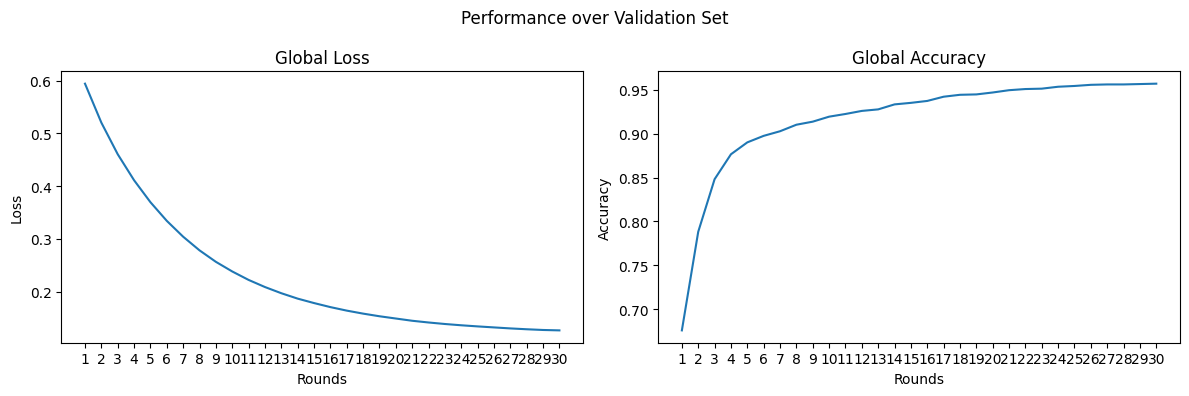

In [38]:
import matplotlib.pyplot as plt

plt.style.use('default')
plt.figure(figsize=(12, 4))
plt.suptitle("Performance over Validation Set")

# Plot for Global Loss
plt.subplot(121)
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.plot(range(1, len(global_loss_list_CNN) + 1), global_loss_list_CNN)
plt.xticks(range(1, len(global_loss_list_CNN) + 1))
plt.title("Global Loss")

# Plot for Global Accuracy
plt.subplot(122)
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.plot(range(1, len(global_accuracy_list_CNN) + 1), global_accuracy_list_CNN)
plt.xticks(range(1, len(global_accuracy_list_CNN) + 1))
plt.title("Global Accuracy")

plt.tight_layout()
plt.show()


In [39]:
train_loss, train_acc = global_model.evaluate(X_train, y_train)
print(f"Global Train Accuracy : {train_acc}")
print(f"Global Train Loss : {train_loss}")


val_loss, val_acc = global_model.evaluate(X_test, y_test)
print(f"Global Validation Accuracy : {val_acc}")
print(f"Global Validation Loss : {val_loss}")
     

286/286 [==============================] - 1s 2ms/step - loss: 0.1347 - accuracy: 0.9493
Global Train Accuracy : 0.9492563605308533
Global Train Loss : 0.13472220301628113
72/72 [==============================] - 0s 2ms/step - loss: 0.1268 - accuracy: 0.9571
Global Validation Accuracy : 0.9571303725242615
Global Validation Loss : 0.12677909433841705


In [40]:
import tensorflow as tf
from sklearn.metrics import classification_report

# Generate predictions
predictions = global_model.predict(X_test)

# Convert probabilities to binary labels
predicted_labels = (predictions > 0.5).astype("int32").flatten()  # Convert to 1D array

# Check the shape of y_test
print("y_test shape:", y_test.shape)

# If y_test is one-hot encoded, convert it to binary labels
if len(y_test.shape) == 2 and y_test.shape[1] == 2:  # Assuming two classes
    true_labels = tf.argmax(y_test, axis=1).numpy()  # Convert to 1D array
else:
    true_labels = y_test  # Already 1D array

# Print classification metrics
class_report = classification_report(true_labels, predicted_labels, digits=6, zero_division=0)
print(class_report)

72/72 [==============================] - 0s 796us/step
y_test shape: (2286,)
              precision    recall  f1-score   support

           0   0.955288  0.960242  0.957759      1157
           1   0.959038  0.953942  0.956483      1129

    accuracy                       0.957130      2286
   macro avg   0.957163  0.957092  0.957121      2286
weighted avg   0.957140  0.957130  0.957129      2286



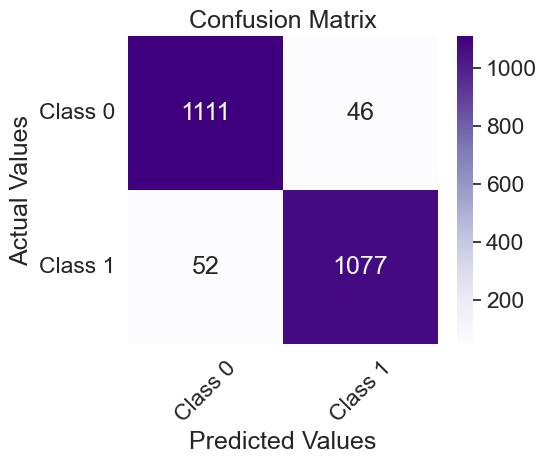

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming true_labels and predicted_labels are already defined

# Define class names for your binary classification
class_names = ['Class 0', 'Class 1']  # Replace with your actual class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.5)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=True, 
                 xticklabels=class_names, yticklabels=class_names)

# Labeling the axes
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names, rotation=0)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

# Show the plot
plt.title('Confusion Matrix')
plt.show()

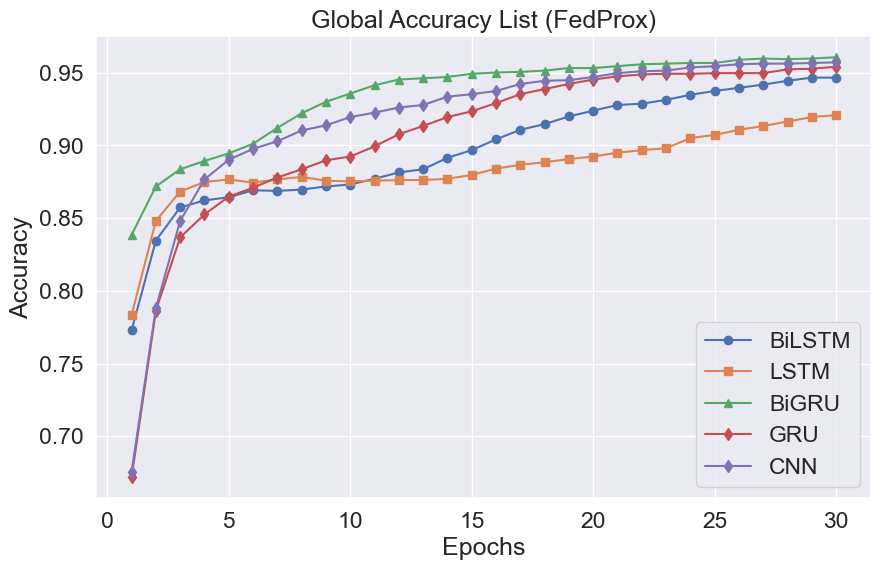

In [45]:
import matplotlib.pyplot as plt

# Define epochs
epochs = list(range(1, 31))  # 1 to 30

# Plot accuracy for each model
plt.figure(figsize=(10, 6))

plt.plot(epochs, global_accuracy_list_BiLSTM, label="BiLSTM", marker='o')
plt.plot(epochs, global_accuracy_list_LSTM, label="LSTM", marker='s')
plt.plot(epochs, global_accuracy_list_BiGRU, label="BiGRU", marker='^')
plt.plot(epochs, global_accuracy_list_GRU, label="GRU", marker='d')
plt.plot(epochs, global_accuracy_list_CNN, label="CNN", marker='d')
# Labels and title
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Global Accuracy List (FedProx)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


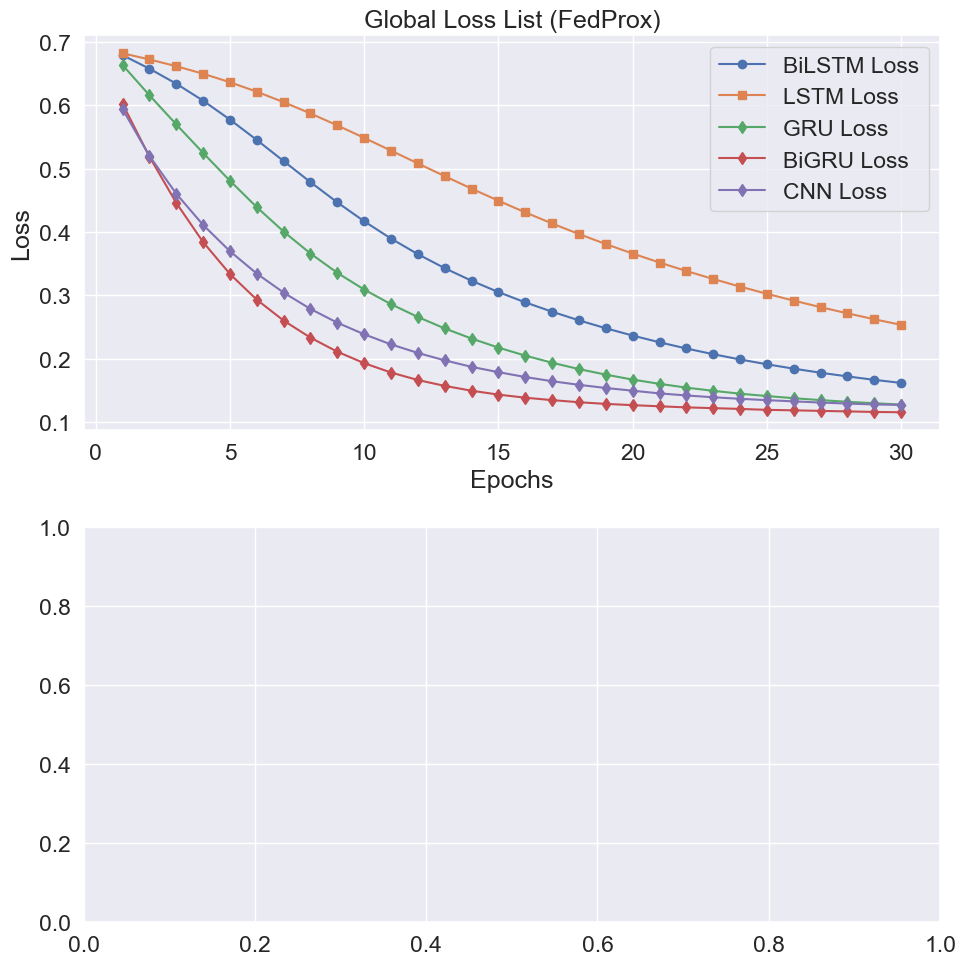

In [44]:
import matplotlib.pyplot as plt

# Define epochs
epochs = list(range(1, 31))  # 1 to 30

# Create a figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# 📉 Plot Loss for BiLSTM, LSTM, GRU
ax[0].plot(epochs, global_loss_list_BiLSTM, label="BiLSTM Loss", marker='o')
ax[0].plot(epochs, global_loss_list_LSTM, label="LSTM Loss", marker='s')
ax[0].plot(epochs, global_loss_list_GRU, label="GRU Loss", marker='d')
ax[0].plot(epochs, global_loss_list_BiGRU, label="BiGRU Loss", marker='d')
ax[0].plot(epochs, global_loss_list_CNN, label="CNN Loss", marker='d')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Global Loss List (FedProx)")
ax[0].legend()
ax[0].grid(True)


# Adjust layout and show plot
plt.tight_layout()
plt.show()
